In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from geopy.distance import geodesic
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Concatenate, Normalization

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/elsamaulida5/machine-learning/main/cleaned%20data/laundry.csv')

In [3]:
data.isna().sum()

ID Laundry           0
Name                 0
Fulladdress          2
Categories           0
phone              131
Review Count         0
Average Rating       0
Review URL          24
Google Maps URL      0
Latitude             0
Longitude            0
Website            760
Opening Hours      102
Featured Image       8
Layanan              3
dtype: int64

In [4]:
data = data.fillna('None')
data.isna().sum()

ID Laundry         0
Name               0
Fulladdress        0
Categories         0
phone              0
Review Count       0
Average Rating     0
Review URL         0
Google Maps URL    0
Latitude           0
Longitude          0
Website            0
Opening Hours      0
Featured Image     0
Layanan            0
dtype: int64

In [5]:
data['Layanan'].unique()

array(['just wash, dry cleaning, iron wash', 'just wash, iron wash',
       'just wash, dry cleaning, iron wash, self laundry', 'None',
       'just wash, dry cleaning, iron wash, carpet laundry',
       'just wash, dry cleaning, iron wash, shoe laundry',
       'just wash, iron wash, self laundry',
       'just wash, dry cleaning, shoe laundry, iron wash, carpet laundry',
       'just wash, car seat laundry, iron wash',
       'just wash, dry cleaning, car seat laundry, iron wash',
       'self laundry'], dtype=object)

In [6]:
# Kata kunci untuk self-service
keyword = 'self laundry'

# Memfilter laundry yang termasuk self-service berdasarkan kata kunci
self_service_df = data[data['Layanan'].str.contains(keyword, case=False, na=False)]

# Menampilkan hasil
#print("Data yang memiliki layanan self-service:")
#self_service_df

In [7]:
import pandas as pd
from geopy.distance import geodesic

# Persiapkan data lokasi pengguna
user_location = (-7.31678, 112.761146)  # Koordinat lokasi pengguna

# Fungsi untuk menghitung jarak antara lokasi pengguna dan setiap laundry
def calculate_distance(row):
    laundry_location = (row['Latitude'], row['Longitude'])
    return geodesic(user_location, laundry_location).kilometers

# Hitung jarak dari lokasi pengguna ke setiap laundry
self_service_df['Distance'] = self_service_df.apply(calculate_distance, axis=1)

if not self_service_df.empty:
    # Urutkan DataFrame berdasarkan jarak terdekat
    nearest_laundries = self_service_df.sort_values(by='Distance')

    # Ambil 5 laundry terdekat sebagai rekomendasi
    recommendations = nearest_laundries.head(10)

    # 4. Evaluasi Model (Misalnya: Visualisasi Rekomendasi)
    # Anda dapat memvisualisasikan rekomendasi dalam peta atau grafik lainnya

    # Tampilkan hasil rekomendasi
    print("Rekomendasi Laundry Self-Service Terdekat:")
    print(recommendations[['Name', 'Distance']])
else:
    # Tidak ada laundry self-service yang tersedia
    print("Maaf, tidak ada laundry self-service yang tersedia di dekat lokasi Anda.")
    # Anda bisa memberikan rekomendasi alternatif atau menawarkan layanan lain kepada pengguna

Rekomendasi Laundry Self-Service Terdekat:
                                  Name     Distance
964                     Adeeva Laundry     2.339385
147                    Humaira Laundry   561.405391
101                    Laundry Sendiri   565.256017
110          Cleanlite Laundry Bandung   568.903367
163   Green.Point Laundry Antar jemput   570.117717
16              Pusat Laundry Nasional   571.415076
691                  Freshclin Laundry   664.313353
704                       Bong Laundry   680.582626
1097                    Bamb's Laundry  1987.541202


<ipython-input-7-f1a73d32eb8e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self_service_df['Distance'] = self_service_df.apply(calculate_distance, axis=1)


#### Model Self Service (Tensorflow)

In [8]:
def prepare_data(self_service_df, user_location):
    # Menambahkan fitur jarak ke lokasi pengguna
    self_service_df['Distance'] = self_service_df.apply(lambda row: geodesic(user_location, (row['Latitude'], row['Longitude'])).km, axis=1)

    # Membuat fitur dan label dengan fitur jarak
    features = self_service_df[['Latitude', 'Longitude', 'Distance']]
    labels = self_service_df['Average Rating']

    # Split data menjadi train dan test
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Normalisasi fitur
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [9]:
def build_model():
    # Input layer
    latitude_input = Input(shape=(1,), name='latitude')
    longitude_input = Input(shape=(1,), name='longitude')
    distance_input = Input(shape=(1,), name='distance')

    # Menggabungkan input
    concatenated = Concatenate()([latitude_input, longitude_input, distance_input])

    # Normalize the concatenated inputs
    normalizer = Normalization()
    normalizer.adapt(np.array([[0, 0, 0], [1, 1, 1]]))  # Dummy data to adapt normalizer

    # Membangun model neural network
    x = Dense(256, activation='relu')(concatenated)
    x = Dense(128, activation='relu')(concatenated)
    x = Dense(64, activation='relu')(concatenated)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    # Model
    model = Model(inputs=[latitude_input, longitude_input, distance_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')  # Use MSE as the loss function

    return model

def train_model(model, X_train_scaled, X_test_scaled, y_train, y_test):
    # Membuat dataset TensorFlow dengan dua input terpisah
    def split_lat_lon_distance(features, label):
        latitude = features[0]
        longitude = features[1]
        distance = features[2]
        return {'latitude': latitude, 'longitude': longitude, 'distance': distance}, label

    # Membuat dataset dengan map function untuk memisahkan latitude dan longitude
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train.values))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train_scaled)).map(split_lat_lon_distance).batch(32)

    test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test.values))
    test_dataset = test_dataset.map(split_lat_lon_distance).batch(32)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Melatih model
    history = model.fit(train_dataset, epochs=200, validation_data=test_dataset, callbacks=[early_stopping])

    # Evaluasi model
    loss = model.evaluate(test_dataset)
    print("Test Loss:", loss)

    # Prediksi
    y_pred = model.predict(test_dataset).flatten()  # Pastikan bentuknya sesuai
    # Menghitung metrik tambahan
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)

    return history

In [12]:
def save_model(model, filename):
    model.save(filename)

def main(self_service_df, user_location):
    X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(self_service_df, user_location)
    model = build_model()
    history = train_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    save_model(model, "model_SelfService.h5")
    return model, history

model, history = main(self_service_df, user_location)

<ipython-input-8-a55f6d13727a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self_service_df['Distance'] = self_service_df.apply(lambda row: geodesic(user_location, (row['Latitude'], row['Longitude'])).km, axis=1)


Epoch 1/200
1/1 [==============================] - 1s 813ms/step - loss: 18.9321 - val_loss: 24.0906
Epoch 2/200
1/1 [==============================] - 0s 50ms/step - loss: 18.6996 - val_loss: 23.7679
Epoch 3/200
1/1 [==============================] - 0s 37ms/step - loss: 18.4702 - val_loss: 23.4618
Epoch 4/200
1/1 [==============================] - 0s 36ms/step - loss: 18.2501 - val_loss: 23.1578
Epoch 5/200
1/1 [==============================] - 0s 37ms/step - loss: 18.0309 - val_loss: 22.8474
Epoch 6/200
1/1 [==============================] - 0s 42ms/step - loss: 17.8250 - val_loss: 22.5468
Epoch 7/200
1/1 [==============================] - 0s 37ms/step - loss: 17.6317 - val_loss: 22.2476
Epoch 8/200
1/1 [==============================] - 0s 40ms/step - loss: 17.4399 - val_loss: 21.9507
Epoch 9/200
1/1 [==============================] - 0s 37ms/step - loss: 17.2563 - val_loss: 21.6607
Epoch 10/200
1/1 [==============================] - 0s 36ms/step - loss: 17.0829 - val_loss: 21.385

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


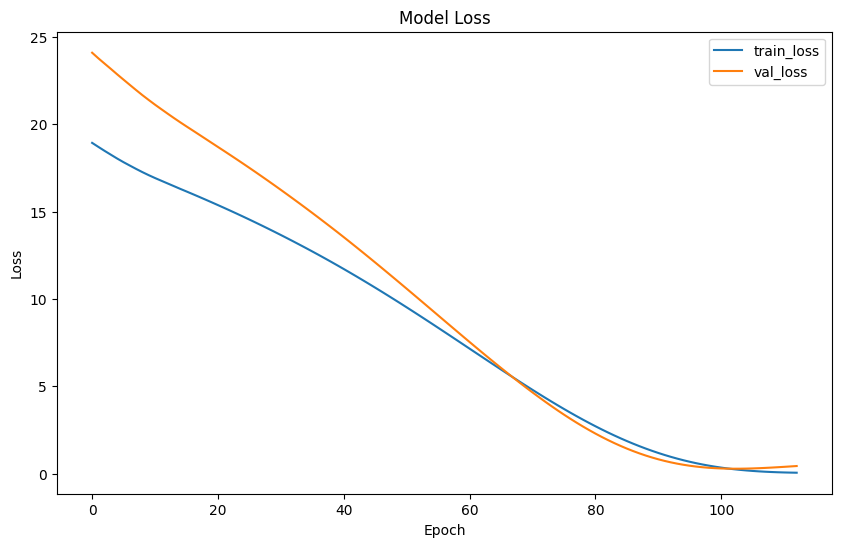

In [13]:
# Load the saved model
model = load_model("model_SelfService.h5")

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [16]:
# Menjalankan Model_SelfService.h5
# Fungsi Haversine
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371
    return c * r

def find_nearest_places(self_service_df, user_location, model_path):
    model = load_model(model_path)

    # Menghitung jarak dari lokasi pengguna ke setiap tempat
    self_service_df.loc[:, 'Distance'] = self_service_df.apply(lambda row: haversine(user_location[1], user_location[0], row['Longitude'], row['Latitude']), axis=1)

    # Menyusun tempat berdasarkan prediksi rating dan jarak
    recommended_places = self_service_df.sort_values(by=['Distance'], ascending=[True])

    # Membatasi hasil menjadi 10 tempat terdekat
    top_10_places = recommended_places.head(10)

    return top_10_places

def print_nearest_places(nearest_places, user_location):
    selected_columns = ['Name', 'Fulladdress', 'Categories', 'phone', 'Average Rating', 'Distance', 'Google Maps URL','Website', 'Opening Hours', 'Layanan']

    # Filter tempat yang berada dalam jarak 500 km
    nearest_places_within_50km = nearest_places[nearest_places['Distance'] <= 50]

    if nearest_places_within_50km.empty:
        print("Tidak ada tempat laundry yang ditemukan")
        return

    for index, row in nearest_places.iterrows():
      print(f"Nama Laundry: {row['Name']}")
      print(f"Alamat Lengkap: {row['Fulladdress']}")
      print(f"Telepon: {row['phone']}")
      print(f"Rating: {row['Average Rating']}")
      print(f"Jarak: {row['Distance']:.2f} km")
      print(f"Google Maps URL: {row['Google Maps URL']}")
      print(f"Website: {row['Website']}")
      print(f"Jam Buka: {row['Opening Hours']}")
      print(f"Layanan: {row['Layanan']}")
      print("\n")

# Contoh penggunaan fungsi
user_location = np.array([-7.316781, 112.761146])
nearest_places_sorted = find_nearest_places(self_service_df, user_location, "model_SelfService.h5")
print_nearest_places(nearest_places_sorted, user_location)

Nama Laundry: Adeeva Laundry
Alamat Lengkap: Jl. Raya Semampir No.2c, Medokan Semampir, Kec. Sukolilo, Surabaya, Jawa Timur 6
Telepon: None
Rating: 5.0
Jarak: 2.34 km
Google Maps URL: https://www.google.com/maps?cid=7486667609321958604
Website: None
Jam Buka: Sabtu: [07.00-21.00], Minggu: [07.00-21.00], Senin: [07.00-21.00], Selasa: [07.0
Layanan: self laundry


Nama Laundry: Humaira Laundry
Alamat Lengkap: 3M5V+64H, Jl. Gedebage Wetan, Cisaranten Kidul, Kec. Gedebage, Kota Bandung, Jaw
Telepon: +62 813-8298-6165
Rating: 4.9
Jarak: 560.77 km
Google Maps URL: https://www.google.com/maps?cid=14843328789995545598
Website: None
Jam Buka: Sabtu: [Buka 24 jam], Minggu: [Tutup], Senin: [Buka 24 jam], Selasa: [Buka 24 ja
Layanan: just wash, iron wash, self laundry


Nama Laundry: Laundry Sendiri
Alamat Lengkap: Jl. Margasari No.28, Margasari, Kec. Buahbatu, Kota Bandung, Jawa Barat 40287
Telepon: +62 821-2128-1878
Rating: 4.9
Jarak: 564.61 km
Google Maps URL: https://www.google.com/maps?cid=11